In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.neighbors import KDTree
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

In [9]:
# conda install -c conda-forge xgboost

In [10]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
features = pd.read_csv('features.csv')

In [11]:
train.head()

,id,lat,lon,score
0,0,56.228300,43.945535,0.080523
1,1,56.834244,53.141543,0.104424
2,2,45.042299,41.990170,0.067615
3,3,59.849408,30.387762,0.088038
4,4,59.839643,30.304308,0.099686


In [12]:
### Проверим типы данных

train.dtypes, test.dtypes

(id         int64
 lat      float64
 lon      float64
 score    float64
 dtype: object,
 id       int64
 lat    float64
 lon    float64
 dtype: object)

In [13]:
features.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3701 entries, 0 to 3700
Data columns (total 365 columns):
 #    Column  Dtype  
---   ------  -----  
 0    lat     float64
 1    lon     float64
 2    0       float64
 3    1       float64
 4    2       float64
 5    3       float64
 6    4       float64
 7    5       float64
 8    6       float64
 9    7       float64
 10   8       float64
 11   9       float64
 12   10      float64
 13   11      float64
 14   12      float64
 15   13      float64
 16   14      float64
 17   15      float64
 18   16      float64
 19   17      float64
 20   18      float64
 21   19      float64
 22   20      float64
 23   21      float64
 24   22      float64
 25   23      float64
 26   24      float64
 27   25      float64
 28   26      float64
 29   27      float64
 30   28      float64
 31   29      float64
 32   30      float64
 33   31      float64
 34   32      float64
 35   33      float64
 36   34      float64
 37   35      float64
 38   36    

In [14]:
%%writefile feature_aggregation.py

from sklearn.neighbors import KDTree
import numpy as np

def aggregate_features(lat_lon, features, k=5):
    tree = KDTree(features[['lat', 'lon']])

    # Находим индексы и расстояния до k ближайших соседей в features для каждой точки из lat_lon
    dist, ind = tree.query(lat_lon, k=k)

    aggregated_features = np.zeros((lat_lon.shape[0], features.shape[1]-2)) # Исключаем lat и lon

    for i in range(lat_lon.shape[0]):
        # Выбор признаков ближайших соседей
        neighbors_features = features.iloc[ind[i], 2:] # Исключаем lat и lon из features

        # Вычисление среднего для признаков
        aggregated_features[i, :] = neighbors_features.mean(axis=0)

    return aggregated_features

Overwriting feature_aggregation.py


In [16]:
from feature_aggregation import aggregate_features

In [17]:
aggregated_train_features = aggregate_features(train[['lat', 'lon']].values, features)
aggregated_train_features_df = pd.DataFrame(aggregated_train_features, columns=features.columns[2:])
train_enhanced = pd.concat([train.reset_index(drop=True), aggregated_train_features_df], axis=1)

train_enhanced

,id,lat,lon,score,0,1,2,3,4,5,...,353,354,355,356,357,358,359,360,361,362
0,0,56.228300,43.945535,0.080523,0.147603,0.129969,0.255320,0.162968,0.136168,0.132511,...,0.042424,0.049860,0.108818,0.100973,0.033640,0.017454,0.074790,0.083067,0.127242,0.130657
1,1,56.834244,53.141543,0.104424,0.097842,0.108625,0.191587,0.083409,0.100101,0.092144,...,0.133994,0.150093,0.283185,0.278015,0.239382,0.114812,0.241958,0.233191,0.328694,0.369281
2,2,45.042299,41.990170,0.067615,0.139842,0.108284,0.319973,0.165197,0.141994,0.123891,...,0.125812,0.146659,0.286602,0.242254,0.114247,0.077791,0.237686,0.250375,0.330534,0.342666
3,3,59.849408,30.387762,0.088038,0.423706,0.307596,0.396454,0.510173,0.415261,0.405771,...,0.042529,0.051431,0.115564,0.105902,0.016170,0.005727,0.043882,0.051431,0.081258,0.081486
4,4,59.839643,30.304308,0.099686,0.417369,0.357652,0.455925,0.473464,0.397490,0.403018,...,0.041155,0.048969,0.108089,0.113051,0.028359,0.008761,0.042510,0.048969,0.076001,0.086986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3079,3079,55.674584,37.279505,0.531557,0.624188,0.520925,0.449266,0.768299,0.597892,0.587103,...,0.054600,0.065030,0.101028,0.111454,0.010103,0.011318,0.055936,0.065030,0.071037,0.085758
3080,3080,55.784909,49.188791,0.101631,0.167458,0.200513,0.322255,0.154770,0.141459,0.157365,...,0.038491,0.046175,0.049198,0.061354,0.007665,0.005897,0.039850,0.046175,0.034593,0.047209
3081,3081,55.118828,61.462996,0.125265,0.125391,0.093239,0.300651,0.147700,0.130098,0.104165,...,0.056799,0.055998,0.116086,0.120542,0.040818,0.018647,0.083308,0.096776,0.127477,0.135842
3082,3082,55.649052,37.533877,0.322601,0.673036,0.619698,0.630653,0.767884,0.621978,0.643127,...,0.033043,0.043843,0.090021,0.099041,0.042958,0.012374,0.065898,0.074219,0.095820,0.112814


In [18]:
### Проверим наличие пропущенных значений:

missing_train = train_enhanced.isnull().sum()

print("\nПропущенные значения в обучающей выборке:")
print(missing_train)

missing_values_train = missing_train[missing_train > 0]
print("Пропущенные значения в трэйновой выборке:")
print(missing_values_train)


Пропущенные значения в обучающей выборке:
id       0
lat      0
lon      0
score    0
0        0
        ..
358      0
359      0
360      0
361      0
362      0
Length: 367, dtype: int64
Пропущенные значения в трэйновой выборке:
Series([], dtype: int64)


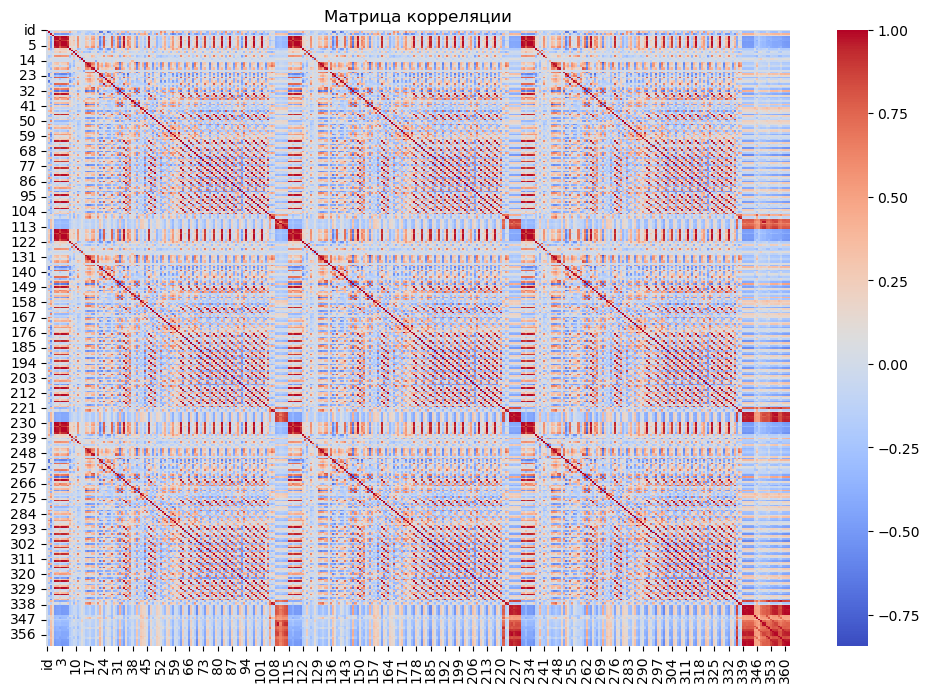

In [19]:
# Построим матрицу корреляции для нашей созданной выборки
corr_matrix = train_enhanced.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Матрица корреляции')
plt.show()

In [20]:
## мы можем наблюдать, как наши признаки с периодичность одинаково описывают наши данные.

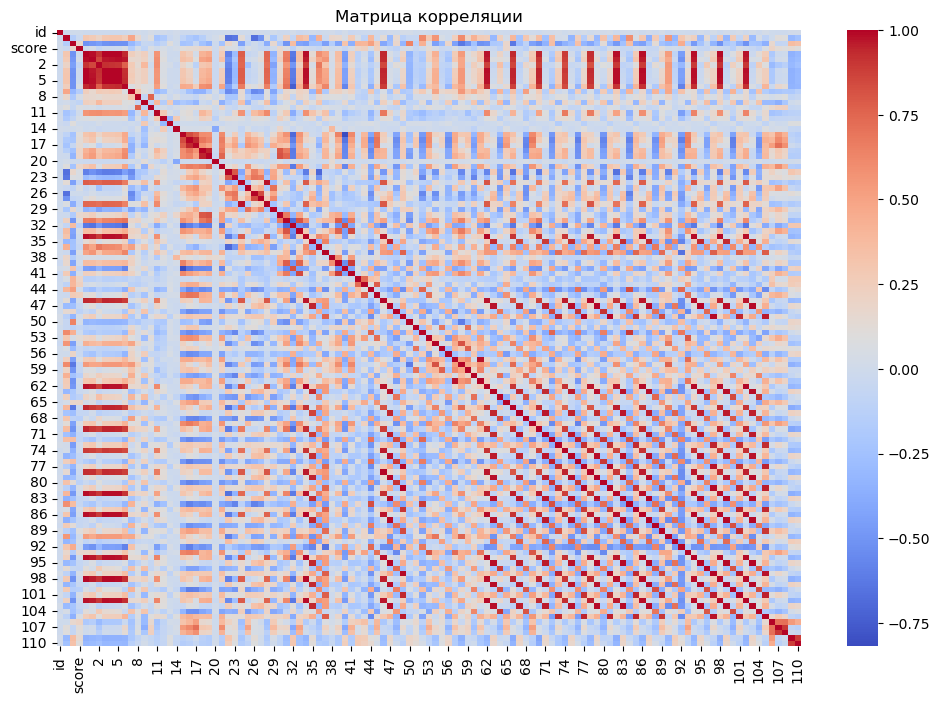

In [21]:
corr_matrix = train_enhanced.iloc[:, :115].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Матрица корреляции')
plt.show()

In [22]:
## Приступим к построению моделей машинного обучения

train = train_enhanced.iloc[:, :115]

X = train.drop(['id', 'score'], axis=1)
y = train['score']

# Разделение данных на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели градиентного бустинга
model = xgb.XGBRegressor(random_state=42)
model.fit(X_train, y_train)

# Предсказание на валидационной выборке
val_preds = model.predict(X_val)

In [23]:
# Оценка качества модели на валидационной выборке
mae = mean_absolute_error(y_val, val_preds)
print("MAE на валидационной выборке:", mae)

mean_score = train_enhanced['score'].mean()
print("Среднее значение целевой переменной:", mean_score)

percent_mae = (mae / mean_score) * 100
print("MAE составляет {:.2f}% от среднего значения целевой переменной".format(percent_mae))

MAE на валидационной выборке: 0.04457191252712401
Среднее значение целевой переменной: 0.1348554837118884
MAE составляет 33.05% от среднего значения целевой переменной


In [24]:
model.save_model('trained_model.model')